In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch  as th
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm
from transformers import Wav2Vec2Model
from torch.utils.data import TensorDataset, DataLoader
import copy


In [2]:
###### Set the device to use Apple M1 GPU #######
device = th.device('mps')

In [94]:
class RandomProjectionQuantizer(nn.Module):
    def __init__(self, input_dim, quantizer_dim, codebook_size, random_state=None, device='cpu'):
        super().__init__()
        self.random_projection = nn.Linear(input_dim, quantizer_dim, bias=False)
        nn.init.xavier_uniform_(self.random_projection.weight)

        self.code_book = nn.Parameter(th.randn(quantizer_dim, codebook_size)).to(device).detach().requires_grad_(False)

        self.random_projection.weight.requires_grad = False
        #self.code_book.requires_grad = False

        self.device = device
        if random_state is not None:
            th.manual_seed(random_state)

    @th.no_grad()
    def forward(self, input_values: th.Tensor, mask_time_indices: th.Tensor) -> th.Tensor:
        """
        Args:
            input_values (torch.Tensor): with shape `(B, L, D)`
            mask_time_indices (torch.Tensor): with shape `(B, L)`

        Returns:
            torch.Tensor with shape `(N)`

        """
        shape = input_values.shape
        targets = self.random_projection(input_values)

        repeated_code_book = self.code_book.unsqueeze(0).unsqueeze(0).expand(shape[0], shape[1], -1, -1)

        # Effectuer l'opération de soustraction
        vector_distances = th.norm(targets.unsqueeze(-1).expand_as(repeated_code_book) - repeated_code_book, dim=2)


        labels = th.argmin(vector_distances, dim=-1)

        return labels

class ASREncoder_technique(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=256, num_layers=5, dropout=0.1):
        super(ASREncoder, self).__init__()

        # Feature extractor (Wav2Vec2 model)
        self.feature_extractor = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
        self.feature_extractor.freeze_feature_extractor()  # Freeze feature extractor

        # Conformer layers
        conformer_layers = []
        for _ in range(num_layers):
            conformer_layers.append(nn.TransformerEncoderLayer(
                d_model=input_dim,
                nhead=4,
                dim_feedforward=hidden_dim,
                dropout=dropout,
                activation='gelu'
            ))
        self.conformer_encoder = nn.TransformerEncoder(nn.ModuleList(conformer_layers), num_layers=num_layers)

        # Classifier head
        self.classifier = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # Extract features using the pre-trained Wav2Vec2 model
        features = self.feature_extractor(x).last_hidden_state

        # Transpose features for Transformer input format (seq_len, batch_size, hidden_dim)
        features = features.permute(1, 0, 2)

        # Apply Conformer layers
        features = self.conformer_encoder(features)

        # Average pooling over time
        pooled_features = torch.mean(features, dim=0)

        # Classification
        output = self.classifier(pooled_features)

        return output

class ExampleEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(80, 192)
        self.num_temporal_dimension_reduction_steps = 4

    def forward(self, inputs, _):
        batch_size, length, _ = inputs.size()

        hidden_states = self.linear(inputs)
        hidden_states = hidden_states.view(batch_size, length, -1)

        return hidden_states

class BestRqFramework(nn.Module):
    def __init__(self, encoder: nn.Module, num_temporal_dimension_reduction_steps: int, input_feature_size: int, encoder_hidden_size: int, num_code_books: int,
                 mask_time: int, stride_time: int, random_state : int, mask_prob: float = 0.1, batch_size : int = 200, num_masks_per_signal :int = 2):
        super().__init__()
        self.K = num_temporal_dimension_reduction_steps
        self.random_state = random_state
        self.batch_size = batch_size
        self.layer_norm = nn.LayerNorm(input_feature_size)
        self.random_projection_quantizer = RandomProjectionQuantizer(input_feature_size, encoder_hidden_size, num_code_books, random_state = random_state)
        self.encoder = encoder
        self.out_linear = nn.Linear(192, num_code_books)
        self.num_time_steps = int(mask_time // (stride_time * self.K))
        self.mask_prob = mask_prob
        self.mask_time = mask_time
        self.num_masks_per_signal = num_masks_per_signal

    def split_batch(self, X, y):
        dataset = TensorDataset(X, y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        return data_loader


    def forward(self, input_values: th.Tensor, input_lengths: th.Tensor):
        """
        Args:
            input_values (th.Tensor): with shape `(B, T, D)`
            input_lengths (th.Tensor): with shape `(B)`

        Returns:

        """

        batch_size, num_steps, hidden_size = input_values.size()


        input_values = self.layer_norm(input_values)

        quantized_input_lengths = input_lengths // self.K - 1

        masked_input_values, time_mask_indices = self.masking(input_values.clone())

        labels = self.random_projection_quantizer(input_values, time_mask_indices)


        encoder_out = self.encoder(masked_input_values, input_lengths)

        print (encoder_out.shape, time_mask_indices.shape, masked_input_values.shape)
        targets = encoder_out[time_mask_indices]
        targets_out = self.out_linear(targets)

        return targets_out, labels



    def masking(self, input_tensor, min_mask=0):
        """
        Generate a mask to randomly mask a subset of values based on the input tensor and probability.

        Args:
        - input_tensor (torch.Tensor): Input tensor for which the mask needs to be generated.
        - prob (float): Probability of masking each valid position.
        - min_mask (float): Minimum number of positions to mask.

        Returns:
        - subset_mask (torch.Tensor): Binary mask indicating positions to be masked (True) and positions to be kept (False).
        """
        batch, seq, device = *input_tensor.shape[:-1], input_tensor.device
        seq_mask = th.ones((batch, seq), dtype=th.bool, device=device)  # Assume all positions are valid

        num_to_mask = (seq_mask.sum(dim=-1, keepdim=True) * self.mask_prob).clamp(min=min_mask)
        logits = th.rand((batch, seq), device=device)
        logits = logits.masked_fill(~seq_mask, -1)

        randperm = logits.argsort(dim=-1).float()

        num_padding = (~seq_mask).sum(dim=-1, keepdim=True)
        randperm -= num_padding

        subset_mask = randperm < num_to_mask
        subset_mask.masked_fill_(~seq_mask, False)
        masked_tensor = input_tensor.clone()
        values_to_change = masked_tensor[subset_mask].clone()
        shape = values_to_change.shape
        for _ in range(self.num_masks_per_signal):
            idx = random.randint(0, int(shape[1]))
            if idx + self.mask_time <= shape[1]:
                values_to_change[:, idx:idx+self.mask_time] = th.normal(mean = 0, std = 0.1, device = device, size= (shape[0], self.mask_time))
        masked_tensor[subset_mask] = values_to_change
        return masked_tensor, subset_mask


    def pretrain(self, xtrain, ytrain, xvalid, yvalid, epochs=10, batch_size=32, lr = 1e-3):
        # Initialize quantizer
        self.quantizer.initialize_quantizer()
        trainloader = self.split_batch(xtrain, ytrain)
        self.optimizer = optim.Adam(self.asr_encoder.parameters(), lr= lr)

        # Iterate over epochs
        for epoch in range(epochs):
            epoch_loss = 0.0

            for inputs, labels in trainloader:

                # Zero gradients
                self.optimizer.zero_grad()

                inputs = inputs.to(device)
                # Forward pass
                labels = self.quantizer.quantize(inputs)
                masked_inputs = self.add_noise_and_mask(inputs)
                predictions = self.asr_encoder(masked_inputs)

                # Compute loss
                loss = self.loss_function(predictions, labels)

                # Backward pass
                loss.backward()

                # Update weights
                self.optimizer.step()

                epoch_loss += loss.item()

            # Print epoch loss
            print(f"Pretraining Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(xtrain)}")


In [8]:
filepath = 'data/cassette-th-data.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
input_dim = xtrain[0].shape
input_dim[0], xtrain.shape

(600, torch.Size([175995, 600]))

In [10]:
device = 'cpu'
tmp = RandomProjectionQuantizer(input_dim= 600, quantizer_dim= 100, codebook_size= 20,random_state= 2673834267383, device = device)
input_size = (175995, 600)
mask_time_indices = th.ones(input_size[0], input_size[1], dtype=th.bool, device= device).to(device)
mask_time_indices = mask_time_indices.view(-1, input_size[1]).unsqueeze(0)
xtrain_batched = xtrain.unsqueeze(0).to(device)
results  = tmp(xtrain_batched, mask_time_indices)
results

tensor([[16,  4,  8,  ..., 15,  9, 10]])

In [100]:
#### Test for Masking
model = BestRqFramework(encoder= ExampleEncoder(),
                        num_temporal_dimension_reduction_steps=100,
                        input_feature_size=80,
                        encoder_hidden_size=20,
                        num_code_books=10,
                        mask_time= 10,
                        stride_time=1,
                        random_state=42,
                        mask_prob=0.1,
                        batch_size=200)


inputs = th.randn(4, 1000, 80).to(device)
    # `(batch size)` Number of available time steps per batch
input_lengths = th.tensor([1000, 871, 389, 487]).to(device)

input_values, idx = model(inputs, input_lengths)


torch.Size([4, 1000, 192]) torch.Size([4, 1000]) torch.Size([4, 1000, 80])


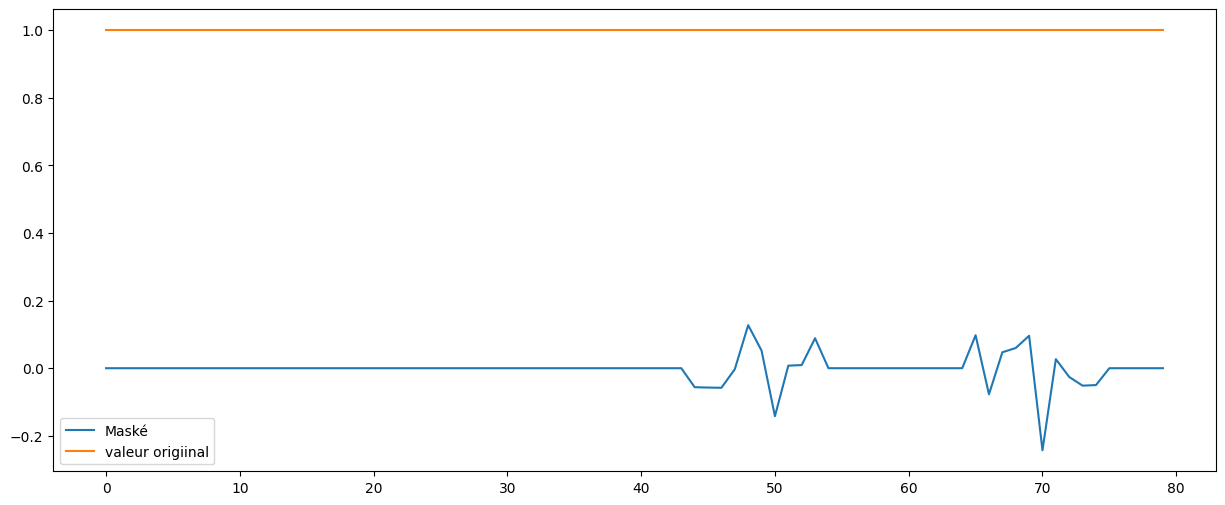

In [43]:
plt.figure(figsize=(15,6))
for i in range(1):
    plt.plot(input_values[1,i,:].detach().numpy(), label = 'Maské')
    plt.plot(inputs[1, i ,:].detach().numpy(), label ='valeur origiinal')
plt.legend()


In [49]:
inputs[idx].view(-1, 1000, 80).shape

torch.Size([1, 1000, 80])

In [111]:
input_values, idx
loss = nn.functional.cross_entropy
loss(input_values.view(4, -1), idx)

RuntimeError: Expected floating point type for target with class probabilities, got Long

In [113]:
(input_values.view(4, -1) == idx).sum()

tensor(0)